In [1]:
import json
import torch
from txtai.embeddings import Embeddings
import ultraprint.common as p

## Flatten Categories

In [2]:
def flatten_categories(data, parent_keys=[]):
    items = []
    for key, value in data.items():
        new_keys = parent_keys + [key]
        if isinstance(value, list):
            for val in value:
                items.append(new_keys + [val])
    return items

def main():
    with open('categories.json', 'r') as f:
        categories = json.load(f)
    
    flattened_categories = flatten_categories(categories)
    
    print("Total categories:")
    print(len(flattened_categories))

    # Create a dictionary to store categories by their first key
    categories_by_key = {}
    for item in flattened_categories:
        key = item[0]
        if key not in categories_by_key:
            categories_by_key[key] = []
        categories_by_key[key].append(item)
    
    # Save each category to a separate file
    for key, items in categories_by_key.items():
        print(f"Processing {key}...")
        print(f"Total items: {len(items)}")
        filename = f'{key}_categories.json'
        with open(filename, 'w') as f:
            json.dump(items, f, indent=4)

main()


Total categories:
19
Processing Genre-Based Classes...
Total items: 8
Processing Emotional or Mood-Based Classes...
Total items: 6
Processing Use-Case or Functional Classes...
Total items: 5


## Vectorize Categories

In [3]:
# Load the JSON file
with open('Emotional or Mood-Based Classes_categories.json', 'r') as f:
    mood_data = json.load(f)

with open('Genre-Based Classes_categories.json', 'r') as f:
    genre_data = json.load(f)

with open('Use-Case or Functional Classes_categories.json', 'r') as f:
    use_case_data = json.load(f)

# Initialize txtai embeddings
embeddings = Embeddings({"path": "sentence-transformers/all-MiniLM-L6-v2", "cache": "./models"})

# Function to embed text
def embed_text(text):
    return embeddings.transform([text])

# Process each array in the JSON
def process_data(data):
    embedded_data = []
    for item in data:
        if len(item) >= 2:
            text_to_embed = ' '.join([item[1]])
            embedding = embed_text(text_to_embed)
            embedded_data.append(embedding)

    embedded_data = torch.tensor(embedded_data).to('cuda')
    return embedded_data

# Embed data from each JSON file
mood_embedded_data = process_data(mood_data)
genre_embedded_data = process_data(genre_data)
use_case_embedded_data = process_data(use_case_data)

# Save the embeddings
torch.save(mood_embedded_data, 'models/mood_embedded_data.pt')
torch.save(genre_embedded_data, 'models/genre_embedded_data.pt')
torch.save(use_case_embedded_data, 'models/use_case_embedded_data.pt')

c:\Users\Ranit Bhowmick\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\Ranit Bhowmick\AppData\Local\Temp\ipykernel_9036\1236502591.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  embedded_data = torch.tensor(embedded_data).to('cuda')


## Vector Search

In [4]:
def get_similarities(string, embeddings):

    # Embed the input string
    input_embedding = torch.tensor(embed_text(string)).to('cuda')

    # Calculate the cosine similarity
    similarities = []
    for embedding in embeddings:
        
        # Compute the dot product
        dot_product = torch.dot(input_embedding, embedding)
        # Compute the norms
        norm_input = torch.norm(input_embedding)
        norm_embedding = torch.norm(embedding)
        
        # Compute the cosine similarity
        similarity = torch.abs(dot_product) / (norm_input * norm_embedding)
        
        similarities.append(similarity.item())
    
    # Return the similarities as a tensor
    similarities = torch.tensor(similarities).to('cuda')

    return similarities

def get_mood_similarities(string):
    return get_similarities(string, mood_embedded_data)

def get_genre_similarities(string):
    return get_similarities(string, genre_embedded_data)

def get_use_case_similarities(string):
    return get_similarities(string, use_case_embedded_data)

In [5]:
sim = get_mood_similarities('I want to learn about the weather')
print(len(sim))
print(mood_data[torch.argmin(sim)])

sim = get_genre_similarities('I want to learn about the weather')
print(len(sim))
print(genre_data[torch.argmin(sim)])

sim = get_use_case_similarities('I want to learn about the weather')
print(len(sim))
print(use_case_data[torch.argmin(sim)])

6
['Emotional or Mood-Based Classes', 'Happy']
8
['Genre-Based Classes', 'Electronic']
5
['Use-Case or Functional Classes', 'Trailer']


# Kaggle

### Get Folder vectorized

In [6]:
import os
import json

# Get genre folders
base_path = "kaggle_data"
genres = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Process each genre and store vectors
genre_vectors = {}
for genre in genres:
    # Get similarities for each category
    mood_sim = get_mood_similarities(genre)
    genre_sim = get_genre_similarities(genre)
    use_case_sim = get_use_case_similarities(genre)
    
    # make the margmax 1 and the rest 0
    mood_sim = torch.where(mood_sim == torch.max(mood_sim), torch.tensor(1).to('cuda'), torch.tensor(0).to('cuda'))
    genre_sim = torch.where(genre_sim == torch.max(genre_sim), torch.tensor(1).to('cuda'), torch.tensor(0).to('cuda'))
    use_case_sim = torch.where(use_case_sim == torch.max(use_case_sim), torch.tensor(1).to('cuda'), torch.tensor(0).to('cuda'))
    
    # Combine the similarities into a single vector
    combined_sim = torch.cat((genre_sim, mood_sim, use_case_sim))
    
    genre_vectors[genre] = combined_sim.tolist()  # Convert tensor to list

# Save to JSON file
with open(base_path + "/filename_similarities.json", "w") as f:
    json.dump(genre_vectors, f, indent=4)

### GetBatch Kaggle

In [7]:
from model import PretrainedAudioClassifier
import os
import json
import random
import numpy as np

def get_batch_kaggle(batch_size=32, base_path="kaggle_data", device='cuda'):
    # Load genre vectors from JSON
    with open(os.path.join(base_path, "filename_similarities.json"), "r") as f:
        genre_vectors = json.load(f)
    
    # Get all genre folders
    genres = list(genre_vectors.keys())
    
    batch_audio_paths = []
    batch_labels = []
    
    while len(batch_audio_paths) < batch_size:
        # Select random genre
        genre = random.choice(genres)
        
        # Get list of WAV files in genre folder
        genre_path = os.path.join(base_path, genre)
        if not os.path.exists(genre_path):
            print(f"Warning: Genre path does not exist: {genre_path}")
            continue
            
        audio_files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        
        if audio_files:
            # Select random audio file
            audio_file = random.choice(audio_files)
            audio_path = os.path.join(genre_path, audio_file)
            
            # Verify file exists
            if not os.path.exists(audio_path):
                print(f"Warning: Audio file does not exist: {audio_path}")
                continue
                
            # Get corresponding genre vector
            genre_vector = genre_vectors[genre]
            
            batch_audio_paths.append(audio_path)
            batch_labels.append(genre_vector)
    
    return batch_audio_paths, torch.tensor(batch_labels, dtype=torch.float32, device=device)

# Example usage:
audio_paths, labels = get_batch_kaggle(batch_size=4)
print("Audio paths:", audio_paths)
print("Labels shape:", labels.shape)


Audio paths: ['kaggle_data\\rock\\rock.00062.wav', 'kaggle_data\\classical\\classical.00076.wav', 'kaggle_data\\classical\\classical.00013.wav', 'kaggle_data\\rock\\rock.00092.wav']
Labels shape: torch.Size([4, 19])


### Train Kaggle

In [31]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm

def train(epochs=100, batch_size=5, learning_rate=0.0001):
    
    # Initialize model and optimizer
    model = PretrainedAudioClassifier(device='cuda')
    model.load('models/pretrained_audio_classifier.pth')
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()  # or appropriate loss function
    
    # Training loop
    for epoch in range(epochs):
        epoch_losses = []
        
        # Create progress bar for each epoch
        with tqdm(range(100), desc=f'Epoch {epoch+1}/{epochs}') as pbar:
            for _ in pbar:

                try:
                    
                    # Get batch
                    audio_paths, labels = get_batch_kaggle(batch_size, device='cuda')

                    # Forward pass
                    probabilities = model(audio_paths)

                    # Check gradient
                    if not probabilities.requires_grad:
                        p.yellow("Warning: probabilities lost gradient tracking")
                        continue

                    # Calculate loss
                    loss = criterion(probabilities, labels)
                    
                    if not loss.requires_grad:
                        p.yellow("Warning: loss lost gradient tracking")
                        continue

                    # Backward pass
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # Track progress
                    epoch_losses.append(loss.item())

                    pbar.set_postfix({'loss': np.mean(epoch_losses)})

                except Exception as e:
                    #print full stack trace
                    p.red(e)
                    continue
        
        # Save model checkpoint every epochs
        model.save('models/pretrained_audio_classifier.pth')
        p.green(f'\nCheckpoint saved at epoch {epoch+1}')
            
        p.blue(f'Epoch {epoch+1} average loss: {np.mean(epoch_losses):.4f}')

# Start training
if __name__ == "__main__":
    train(batch_size=30)

Epoch 1/100:  17%|█▋        | 17/100 [00:07<00:33,  2.46it/s, loss=0.00712]c:\Users\Ranit Bhowmick\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([30, 19])) that is different to the input size (torch.Size([29, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/100:  18%|█▊        | 18/100 [00:07<00:30,  2.68it/s, loss=0.00712]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 1/100:  93%|█████████▎| 93/100 [00:38<00:02,  2.37it/s, loss=0.00415]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 1/100:  94%|█████████▍| 94/100 [00:39<00:02,  2.54it/s, loss=0.00415]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 1/100: 100%|██████████| 100/100 [00:41<00:00,  2.40it/s, loss=0.00405]


 
Checkpoint saved at epoch 1
 Epoch 1 average loss: 0.0041


Epoch 2/100:  51%|█████     | 51/100 [00:21<00:21,  2.26it/s, loss=0.00506]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 2/100:  52%|█████▏    | 52/100 [00:22<00:19,  2.47it/s, loss=0.00506]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 2/100:  87%|████████▋ | 87/100 [00:37<00:05,  2.31it/s, loss=0.00472]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 2/100:  88%|████████▊ | 88/100 [00:37<00:04,  2.49it/s, loss=0.00472]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 2/100: 100%|██████████| 100/100 [00:42<00:00,  2.33it/s, loss=0.00443]


 
Checkpoint saved at epoch 2
 Epoch 2 average loss: 0.0044


Epoch 3/100:  12%|█▏        | 12/100 [00:05<00:35,  2.49it/s, loss=0.00429]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 3/100:  22%|██▏       | 22/100 [00:09<00:31,  2.50it/s, loss=0.00385]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 3/100:  47%|████▋     | 47/100 [00:20<00:23,  2.29it/s, loss=0.00346]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 3/100:  48%|████▊     | 48/100 [00:20<00:20,  2.49it/s, loss=0.00346]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 3/100: 100%|██████████| 100/100 [00:43<00:00,  2.29it/s, loss=0.00359]


 
Checkpoint saved at epoch 3
 Epoch 3 average loss: 0.0036


Epoch 4/100:  35%|███▌      | 35/100 [00:15<00:26,  2.46it/s, loss=0.00405]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 4/100:  84%|████████▍ | 84/100 [00:37<00:07,  2.26it/s, loss=0.00399]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 4/100:  85%|████████▌ | 85/100 [00:37<00:06,  2.45it/s, loss=0.00399]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 4/100: 100%|██████████| 100/100 [00:44<00:00,  2.27it/s, loss=0.00399]


 
Checkpoint saved at epoch 4
 Epoch 4 average loss: 0.0040


Epoch 5/100:  15%|█▌        | 15/100 [00:06<00:34,  2.47it/s, loss=0.00254]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 5/100:  83%|████████▎ | 83/100 [00:36<00:06,  2.43it/s, loss=0.0035] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 5/100:  96%|█████████▌| 96/100 [00:42<00:01,  2.45it/s, loss=0.00356]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 5/100: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s, loss=0.00351]


 
Checkpoint saved at epoch 5
 Epoch 5 average loss: 0.0035


Epoch 6/100:  15%|█▌        | 15/100 [00:06<00:37,  2.24it/s, loss=0.00455]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 6/100:  16%|█▌        | 16/100 [00:07<00:34,  2.41it/s, loss=0.00455]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 6/100:  17%|█▋        | 17/100 [00:07<00:33,  2.50it/s, loss=0.00455]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 6/100:  20%|██        | 20/100 [00:08<00:35,  2.28it/s, loss=0.00433]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 6/100:  21%|██        | 21/100 [00:09<00:33,  2.34it/s, loss=0.00433]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 6/100:  42%|████▏     | 42/100 [00:18<00:25,  2.24it/s, loss=0.00464]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 6/100:  43%|████▎     | 43/100 [00:18<00:23,  2.41it/s, loss=0.00464]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 6/100:  51%|█████     | 51/100 [00:22<00:20,  2.45it/s, loss=0.00455]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 6/100:  91%|█████████ | 91/100 [00:40<00:04,  2.22it/s, loss=0.00523]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 6/100: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s, loss=0.00517]


 
Checkpoint saved at epoch 6
 Epoch 6 average loss: 0.0052


Epoch 7/100:  20%|██        | 20/100 [00:08<00:32,  2.44it/s, loss=0.005]  

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 7/100: 100%|██████████| 100/100 [00:44<00:00,  2.23it/s, loss=0.00421]


 
Checkpoint saved at epoch 7
 Epoch 7 average loss: 0.0042


Epoch 8/100:  27%|██▋       | 27/100 [00:12<00:30,  2.41it/s, loss=0.00449]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 8/100:  49%|████▉     | 49/100 [00:22<00:21,  2.42it/s, loss=0.00368]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 8/100:  55%|█████▌    | 55/100 [00:24<00:18,  2.43it/s, loss=0.00373]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0
Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 8/100:  56%|█████▌    | 56/100 [00:24<00:17,  2.51it/s, loss=0.00373]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 8/100:  58%|█████▊    | 58/100 [00:25<00:18,  2.26it/s, loss=0.00362]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 8/100:  59%|█████▉    | 59/100 [00:26<00:16,  2.44it/s, loss=0.00362]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 8/100:  60%|██████    | 60/100 [00:26<00:17,  2.32it/s, loss=0.00359]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 8/100:  61%|██████    | 61/100 [00:27<00:15,  2.49it/s, loss=0.00359]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 8/100:  67%|██████▋   | 67/100 [00:29<00:14,  2.24it/s, loss=0.00375]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 8/100:  68%|██████▊   | 68/100 [00:30<00:13,  2.41it/s, loss=0.00375]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 8/100:  99%|█████████▉| 99/100 [00:44<00:00,  2.23it/s, loss=0.00366]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 8/100: 100%|██████████| 100/100 [00:44<00:00,  2.25it/s, loss=0.00366]


 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0
 
Checkpoint saved at epoch 8
 Epoch 8 average loss: 0.0037


Epoch 9/100:  12%|█▏        | 12/100 [00:05<00:39,  2.22it/s, loss=0.0045] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 9/100:  13%|█▎        | 13/100 [00:05<00:36,  2.38it/s, loss=0.0045]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 9/100:  18%|█▊        | 18/100 [00:07<00:33,  2.43it/s, loss=0.00433]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 9/100:  22%|██▏       | 22/100 [00:09<00:32,  2.43it/s, loss=0.00423]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 9/100:  44%|████▍     | 44/100 [00:19<00:25,  2.22it/s, loss=0.00388]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 9/100:  45%|████▌     | 45/100 [00:19<00:22,  2.40it/s, loss=0.00388]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 9/100: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.0032]


 
Checkpoint saved at epoch 9
 Epoch 9 average loss: 0.0032


Epoch 10/100:  24%|██▍       | 24/100 [00:10<00:32,  2.32it/s, loss=0.00419]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 10/100:  45%|████▌     | 45/100 [00:20<00:23,  2.37it/s, loss=0.00385]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 10/100: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s, loss=0.00323]


 
Checkpoint saved at epoch 10
 Epoch 10 average loss: 0.0032


Epoch 11/100:   9%|▉         | 9/100 [00:03<00:37,  2.41it/s, loss=0.00276]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 11/100:  12%|█▏        | 12/100 [00:05<00:36,  2.43it/s, loss=0.00302]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 11/100:  47%|████▋     | 47/100 [00:20<00:22,  2.38it/s, loss=0.00329]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 11/100:  57%|█████▋    | 57/100 [00:25<00:19,  2.22it/s, loss=0.00299]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 11/100:  58%|█████▊    | 58/100 [00:25<00:17,  2.37it/s, loss=0.00299]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 11/100:  72%|███████▏  | 72/100 [00:32<00:12,  2.21it/s, loss=0.00277]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 11/100:  73%|███████▎  | 73/100 [00:32<00:11,  2.40it/s, loss=0.00277]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 11/100: 100%|██████████| 100/100 [00:44<00:00,  2.22it/s, loss=0.00281]


 
Checkpoint saved at epoch 11
 Epoch 11 average loss: 0.0028


Epoch 12/100:  20%|██        | 20/100 [00:08<00:33,  2.40it/s, loss=0.00205]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 12/100:  86%|████████▌ | 86/100 [00:39<00:06,  2.19it/s, loss=0.0024] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 12/100:  87%|████████▋ | 87/100 [00:39<00:05,  2.35it/s, loss=0.0024]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 12/100: 100%|██████████| 100/100 [00:45<00:00,  2.40it/s, loss=0.00241]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 12/100: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s, loss=0.00241]


 
Checkpoint saved at epoch 12
 Epoch 12 average loss: 0.0024


Epoch 13/100:  53%|█████▎    | 53/100 [00:24<00:19,  2.40it/s, loss=0.00292]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 13/100:  73%|███████▎  | 73/100 [00:33<00:12,  2.16it/s, loss=0.00298]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 13/100:  96%|█████████▌| 96/100 [00:43<00:01,  2.20it/s, loss=0.00303]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 13/100:  97%|█████████▋| 97/100 [00:44<00:01,  2.37it/s, loss=0.00303]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 13/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00307]


 
Checkpoint saved at epoch 13
 Epoch 13 average loss: 0.0031


Epoch 14/100:  31%|███       | 31/100 [00:13<00:28,  2.39it/s, loss=0.00165]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 14/100:  68%|██████▊   | 68/100 [00:30<00:13,  2.37it/s, loss=0.00229]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 14/100:  97%|█████████▋| 97/100 [00:43<00:01,  2.35it/s, loss=0.00279]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 14/100: 100%|██████████| 100/100 [00:45<00:00,  2.21it/s, loss=0.00277]


 
Checkpoint saved at epoch 14
 Epoch 14 average loss: 0.0028


Epoch 15/100:  81%|████████  | 81/100 [00:36<00:07,  2.41it/s, loss=0.00232]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 15/100:  94%|█████████▍| 94/100 [00:42<00:02,  2.19it/s, loss=0.00242]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 15/100:  95%|█████████▌| 95/100 [00:43<00:02,  2.37it/s, loss=0.00242]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 15/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00236]


 
Checkpoint saved at epoch 15
 Epoch 15 average loss: 0.0024


Epoch 16/100:   1%|          | 1/100 [00:00<00:45,  2.19it/s, loss=0.00314]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 16/100:   2%|▏         | 2/100 [00:00<00:38,  2.55it/s, loss=0.00314]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 16/100:  84%|████████▍ | 84/100 [00:38<00:06,  2.35it/s, loss=0.0034] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 16/100:  94%|█████████▍| 94/100 [00:42<00:02,  2.20it/s, loss=0.00341]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 16/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00352]


 
Checkpoint saved at epoch 16
 Epoch 16 average loss: 0.0035


Epoch 17/100:   9%|▉         | 9/100 [00:04<00:38,  2.35it/s, loss=0.00419]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  18%|█▊        | 18/100 [00:08<00:34,  2.37it/s, loss=0.00374]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  22%|██▏       | 22/100 [00:09<00:35,  2.21it/s, loss=0.00392]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 17/100:  23%|██▎       | 23/100 [00:10<00:32,  2.38it/s, loss=0.00392]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  24%|██▍       | 24/100 [00:10<00:30,  2.45it/s, loss=0.00392]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  27%|██▋       | 27/100 [00:11<00:29,  2.45it/s, loss=0.00379]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  35%|███▌      | 35/100 [00:15<00:29,  2.21it/s, loss=0.00383]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 17/100:  36%|███▌      | 36/100 [00:16<00:27,  2.35it/s, loss=0.00383]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  69%|██████▉   | 69/100 [00:30<00:12,  2.39it/s, loss=0.0033] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100:  79%|███████▉  | 79/100 [00:35<00:08,  2.37it/s, loss=0.00359]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 17/100: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s, loss=0.00309]


 
Checkpoint saved at epoch 17
 Epoch 17 average loss: 0.0031


Epoch 18/100:  39%|███▉      | 39/100 [00:17<00:25,  2.35it/s, loss=0.00218] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 18/100:  54%|█████▍    | 54/100 [00:24<00:19,  2.37it/s, loss=0.00189]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 18/100:  77%|███████▋  | 77/100 [00:35<00:10,  2.14it/s, loss=0.00181]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 18/100:  78%|███████▊  | 78/100 [00:35<00:09,  2.32it/s, loss=0.00181]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 18/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00188]


 
Checkpoint saved at epoch 18
 Epoch 18 average loss: 0.0019


Epoch 19/100:  64%|██████▍   | 64/100 [00:29<00:15,  2.35it/s, loss=0.00183]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 19/100: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s, loss=0.00206]


 
Checkpoint saved at epoch 19
 Epoch 19 average loss: 0.0021


Epoch 20/100:   8%|▊         | 8/100 [00:03<00:42,  2.14it/s, loss=0.00226]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 20/100:   9%|▉         | 9/100 [00:04<00:40,  2.27it/s, loss=0.00226]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 20/100:  76%|███████▌  | 76/100 [00:34<00:11,  2.17it/s, loss=0.00228]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 20/100:  77%|███████▋  | 77/100 [00:35<00:09,  2.34it/s, loss=0.00228]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 20/100:  90%|█████████ | 90/100 [00:41<00:04,  2.18it/s, loss=0.00224]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 20/100:  91%|█████████ | 91/100 [00:41<00:03,  2.34it/s, loss=0.00224]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 20/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00229]


 
Checkpoint saved at epoch 20
 Epoch 20 average loss: 0.0023


Epoch 21/100:  14%|█▍        | 14/100 [00:06<00:39,  2.17it/s, loss=0.00167]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 21/100:  15%|█▌        | 15/100 [00:06<00:36,  2.32it/s, loss=0.00167]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 21/100:  24%|██▍       | 24/100 [00:11<00:34,  2.18it/s, loss=0.0019] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 21/100:  25%|██▌       | 25/100 [00:11<00:32,  2.33it/s, loss=0.0019]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 21/100:  26%|██▌       | 26/100 [00:11<00:33,  2.24it/s, loss=0.00187]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 21/100:  27%|██▋       | 27/100 [00:12<00:30,  2.40it/s, loss=0.00187]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 21/100:  88%|████████▊ | 88/100 [00:40<00:05,  2.36it/s, loss=0.00229]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 21/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00216]


 
Checkpoint saved at epoch 21
 Epoch 21 average loss: 0.0022


Epoch 22/100:  26%|██▌       | 26/100 [00:11<00:33,  2.19it/s, loss=0.00135]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 22/100:  27%|██▋       | 27/100 [00:12<00:30,  2.37it/s, loss=0.00135]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 22/100:  67%|██████▋   | 67/100 [00:30<00:14,  2.34it/s, loss=0.00181]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 22/100:  68%|██████▊   | 68/100 [00:30<00:13,  2.43it/s, loss=0.00181]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 22/100:  70%|███████   | 70/100 [00:31<00:12,  2.45it/s, loss=0.00183]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 22/100:  91%|█████████ | 91/100 [00:41<00:04,  2.13it/s, loss=0.00198]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 22/100:  92%|█████████▏| 92/100 [00:41<00:03,  2.30it/s, loss=0.00198]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 22/100:  93%|█████████▎| 93/100 [00:42<00:03,  2.22it/s, loss=0.00197]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 22/100:  94%|█████████▍| 94/100 [00:42<00:02,  2.38it/s, loss=0.00197]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 22/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00191]


 
Checkpoint saved at epoch 22
 Epoch 22 average loss: 0.0019


Epoch 23/100:   7%|▋         | 7/100 [00:03<00:38,  2.39it/s, loss=0.00231] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 23/100:  15%|█▌        | 15/100 [00:06<00:35,  2.38it/s, loss=0.00305]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 23/100:  72%|███████▏  | 72/100 [00:32<00:11,  2.38it/s, loss=0.00253]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 23/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00241]


 
Checkpoint saved at epoch 23
 Epoch 23 average loss: 0.0024


Epoch 24/100:  47%|████▋     | 47/100 [00:21<00:23,  2.21it/s, loss=0.00173] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 24/100:  48%|████▊     | 48/100 [00:21<00:22,  2.36it/s, loss=0.00173]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 24/100:  66%|██████▌   | 66/100 [00:30<00:14,  2.38it/s, loss=0.00153]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 24/100:  91%|█████████ | 91/100 [00:41<00:03,  2.36it/s, loss=0.0018] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 24/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00201]


 
Checkpoint saved at epoch 24
 Epoch 24 average loss: 0.0020


Epoch 25/100:  19%|█▉        | 19/100 [00:08<00:37,  2.19it/s, loss=0.00234]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 25/100:  20%|██        | 20/100 [00:09<00:34,  2.34it/s, loss=0.00234]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 25/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00207]


 
Checkpoint saved at epoch 25
 Epoch 25 average loss: 0.0021


Epoch 26/100:   5%|▌         | 5/100 [00:02<00:39,  2.39it/s, loss=0.000577]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 26/100:  32%|███▏      | 32/100 [00:14<00:28,  2.39it/s, loss=0.00212]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 26/100:  57%|█████▋    | 57/100 [00:25<00:18,  2.36it/s, loss=0.00198]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 26/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00174]


 
Checkpoint saved at epoch 26
 Epoch 26 average loss: 0.0017


Epoch 27/100:  75%|███████▌  | 75/100 [00:34<00:10,  2.35it/s, loss=0.00207] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 27/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00222]


 
Checkpoint saved at epoch 27
 Epoch 27 average loss: 0.0022


Epoch 28/100:  13%|█▎        | 13/100 [00:05<00:36,  2.38it/s, loss=0.00274]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 28/100:  28%|██▊       | 28/100 [00:12<00:33,  2.18it/s, loss=0.00231]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 28/100:  29%|██▉       | 29/100 [00:13<00:30,  2.34it/s, loss=0.00231]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 28/100:  30%|███       | 30/100 [00:13<00:28,  2.44it/s, loss=0.00231]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 28/100:  50%|█████     | 50/100 [00:22<00:23,  2.17it/s, loss=0.00206]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 28/100:  51%|█████     | 51/100 [00:23<00:21,  2.32it/s, loss=0.00206]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 28/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00234]


 
Checkpoint saved at epoch 28
 Epoch 28 average loss: 0.0023


Epoch 29/100:  39%|███▉      | 39/100 [00:17<00:27,  2.19it/s, loss=0.00244]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 29/100:  40%|████      | 40/100 [00:18<00:25,  2.36it/s, loss=0.00244]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 29/100:  48%|████▊     | 48/100 [00:21<00:21,  2.39it/s, loss=0.00228]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 29/100:  88%|████████▊ | 88/100 [00:39<00:05,  2.38it/s, loss=0.00285]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 29/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00282]


 
Checkpoint saved at epoch 29
 Epoch 29 average loss: 0.0028


Epoch 30/100:  22%|██▏       | 22/100 [00:10<00:33,  2.33it/s, loss=0.00181]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 30/100:  25%|██▌       | 25/100 [00:11<00:31,  2.39it/s, loss=0.00182]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 30/100:  32%|███▏      | 32/100 [00:14<00:31,  2.19it/s, loss=0.00158]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 30/100:  33%|███▎      | 33/100 [00:14<00:28,  2.37it/s, loss=0.00158]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 30/100:  54%|█████▍    | 54/100 [00:24<00:21,  2.18it/s, loss=0.00138]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 30/100:  55%|█████▌    | 55/100 [00:24<00:19,  2.36it/s, loss=0.00138]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 30/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00182]


 
Checkpoint saved at epoch 30
 Epoch 30 average loss: 0.0018


Epoch 31/100:  32%|███▏      | 32/100 [00:14<00:28,  2.35it/s, loss=0.00268]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 31/100:  63%|██████▎   | 63/100 [00:28<00:16,  2.20it/s, loss=0.00232]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 31/100:  64%|██████▍   | 64/100 [00:29<00:15,  2.38it/s, loss=0.00232]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 31/100:  80%|████████  | 80/100 [00:36<00:08,  2.36it/s, loss=0.00218]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 31/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00208]


 
Checkpoint saved at epoch 31
 Epoch 31 average loss: 0.0021


Epoch 32/100:   9%|▉         | 9/100 [00:04<00:41,  2.19it/s, loss=0.00152]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 32/100:  10%|█         | 10/100 [00:04<00:38,  2.35it/s, loss=0.00152]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 32/100:  44%|████▍     | 44/100 [00:19<00:23,  2.39it/s, loss=0.00192]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 32/100:  54%|█████▍    | 54/100 [00:24<00:20,  2.22it/s, loss=0.00207]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 32/100:  62%|██████▏   | 62/100 [00:28<00:16,  2.36it/s, loss=0.00189]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 32/100:  93%|█████████▎| 93/100 [00:42<00:03,  2.19it/s, loss=0.00171]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 32/100:  94%|█████████▍| 94/100 [00:42<00:02,  2.36it/s, loss=0.00171]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 32/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00169]


 
Checkpoint saved at epoch 32
 Epoch 32 average loss: 0.0017


Epoch 33/100:  13%|█▎        | 13/100 [00:06<00:40,  2.17it/s, loss=0.00136]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 33/100:  14%|█▍        | 14/100 [00:06<00:36,  2.35it/s, loss=0.00136]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 33/100:  54%|█████▍    | 54/100 [00:24<00:20,  2.20it/s, loss=0.00148]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 33/100:  55%|█████▌    | 55/100 [00:25<00:19,  2.36it/s, loss=0.00148]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 33/100:  58%|█████▊    | 58/100 [00:26<00:17,  2.37it/s, loss=0.00143]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 33/100:  77%|███████▋  | 77/100 [00:35<00:09,  2.37it/s, loss=0.00166]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 33/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00178]


 
Checkpoint saved at epoch 33
 Epoch 33 average loss: 0.0018


Epoch 34/100:   4%|▍         | 4/100 [00:01<00:43,  2.19it/s, loss=0.00134] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 34/100:   5%|▌         | 5/100 [00:02<00:39,  2.42it/s, loss=0.00134]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 34/100:  17%|█▋        | 17/100 [00:07<00:37,  2.19it/s, loss=0.00158]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 34/100:  18%|█▊        | 18/100 [00:08<00:36,  2.22it/s, loss=0.00158]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 34/100:  26%|██▌       | 26/100 [00:11<00:34,  2.16it/s, loss=0.00198]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 34/100:  27%|██▋       | 27/100 [00:12<00:31,  2.33it/s, loss=0.00198]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 34/100:  82%|████████▏ | 82/100 [00:37<00:08,  2.18it/s, loss=0.00147]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 34/100:  83%|████████▎ | 83/100 [00:37<00:07,  2.35it/s, loss=0.00147]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 34/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00141]


 
Checkpoint saved at epoch 34
 Epoch 34 average loss: 0.0014


Epoch 35/100:  38%|███▊      | 38/100 [00:17<00:28,  2.16it/s, loss=0.00147]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 35/100:  39%|███▉      | 39/100 [00:17<00:26,  2.33it/s, loss=0.00147]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 35/100:  49%|████▉     | 49/100 [00:22<00:21,  2.36it/s, loss=0.00159]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 35/100:  94%|█████████▍| 94/100 [00:43<00:02,  2.18it/s, loss=0.00142]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 35/100:  95%|█████████▌| 95/100 [00:43<00:02,  2.34it/s, loss=0.00142]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 35/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00137]


 
Checkpoint saved at epoch 35
 Epoch 35 average loss: 0.0014


Epoch 36/100:  41%|████      | 41/100 [00:18<00:28,  2.09it/s, loss=0.00158] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 36/100:  42%|████▏     | 42/100 [00:19<00:25,  2.27it/s, loss=0.00158]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 36/100:  67%|██████▋   | 67/100 [00:30<00:14,  2.35it/s, loss=0.00156]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 36/100:  75%|███████▌  | 75/100 [00:34<00:10,  2.38it/s, loss=0.0016] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 36/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.0014]


 
Checkpoint saved at epoch 36
 Epoch 36 average loss: 0.0014


Epoch 37/100:  11%|█         | 11/100 [00:04<00:37,  2.37it/s, loss=0.00244]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 37/100:  35%|███▌      | 35/100 [00:15<00:29,  2.20it/s, loss=0.0022] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 37/100:  36%|███▌      | 36/100 [00:16<00:26,  2.39it/s, loss=0.0022]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 37/100:  45%|████▌     | 45/100 [00:20<00:25,  2.18it/s, loss=0.00194]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 37/100:  46%|████▌     | 46/100 [00:20<00:23,  2.34it/s, loss=0.00194]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 37/100:  61%|██████    | 61/100 [00:27<00:17,  2.19it/s, loss=0.00159]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


c:\Users\Ranit Bhowmick\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([30, 19])) that is different to the input size (torch.Size([28, 19])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 37/100:  62%|██████▏   | 62/100 [00:28<00:15,  2.39it/s, loss=0.00159]

 The size of tensor a (28) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 37/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00157]


 
Checkpoint saved at epoch 37
 Epoch 37 average loss: 0.0016


Epoch 38/100:  49%|████▉     | 49/100 [00:22<00:21,  2.37it/s, loss=0.0022] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 38/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00222]


 
Checkpoint saved at epoch 38
 Epoch 38 average loss: 0.0022


Epoch 39/100:   3%|▎         | 3/100 [00:01<00:39,  2.47it/s, loss=0.00377]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 39/100:   8%|▊         | 8/100 [00:03<00:39,  2.30it/s, loss=0.00399]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 39/100:  65%|██████▌   | 65/100 [00:29<00:14,  2.33it/s, loss=0.00276]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 39/100:  97%|█████████▋| 97/100 [00:44<00:01,  2.35it/s, loss=0.00274]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 39/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00268]


 
Checkpoint saved at epoch 39
 Epoch 39 average loss: 0.0027


Epoch 40/100:  38%|███▊      | 38/100 [00:17<00:26,  2.36it/s, loss=0.00155] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 40/100:  41%|████      | 41/100 [00:18<00:26,  2.23it/s, loss=0.00156]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 40/100:  42%|████▏     | 42/100 [00:19<00:24,  2.35it/s, loss=0.00156]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 40/100:  49%|████▉     | 49/100 [00:22<00:21,  2.37it/s, loss=0.00159]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (28) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 40/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00168]


 
Checkpoint saved at epoch 40
 Epoch 40 average loss: 0.0017


Epoch 41/100:   1%|          | 1/100 [00:00<00:34,  2.85it/s]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 41/100:   8%|▊         | 8/100 [00:03<00:41,  2.20it/s, loss=0.000935]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 41/100:   9%|▉         | 9/100 [00:03<00:38,  2.36it/s, loss=0.000935]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 41/100:  21%|██        | 21/100 [00:09<00:33,  2.34it/s, loss=0.00128] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 41/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00135]


 
Checkpoint saved at epoch 41
 Epoch 41 average loss: 0.0014


Epoch 42/100:  87%|████████▋ | 87/100 [00:39<00:05,  2.34it/s, loss=0.00156]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 42/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00147]


 
Checkpoint saved at epoch 42
 Epoch 42 average loss: 0.0015


Epoch 43/100:   4%|▍         | 4/100 [00:01<00:39,  2.41it/s, loss=0.00351]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 43/100:  26%|██▌       | 26/100 [00:11<00:34,  2.17it/s, loss=0.00201]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 43/100:  27%|██▋       | 27/100 [00:12<00:31,  2.34it/s, loss=0.00201]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 43/100:  35%|███▌      | 35/100 [00:16<00:29,  2.18it/s, loss=0.00196]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 43/100:  36%|███▌      | 36/100 [00:16<00:27,  2.35it/s, loss=0.00196]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 43/100:  58%|█████▊    | 58/100 [00:26<00:17,  2.36it/s, loss=0.00187]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 43/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00154]


 
Checkpoint saved at epoch 43
 Epoch 43 average loss: 0.0015


Epoch 44/100:   4%|▍         | 4/100 [00:01<00:39,  2.40it/s, loss=0.00229]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 44/100:  64%|██████▍   | 64/100 [00:29<00:15,  2.36it/s, loss=0.00113] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 44/100:  75%|███████▌  | 75/100 [00:34<00:10,  2.39it/s, loss=0.00118]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 44/100:  83%|████████▎ | 83/100 [00:37<00:07,  2.18it/s, loss=0.00113]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 44/100:  84%|████████▍ | 84/100 [00:38<00:06,  2.33it/s, loss=0.00113]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 44/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00114]


 
Checkpoint saved at epoch 44
 Epoch 44 average loss: 0.0011


Epoch 45/100:  18%|█▊        | 18/100 [00:08<00:37,  2.19it/s, loss=0.000863]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 45/100:  19%|█▉        | 19/100 [00:08<00:34,  2.35it/s, loss=0.000863]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 45/100:  20%|██        | 20/100 [00:08<00:32,  2.44it/s, loss=0.000863]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 45/100:  32%|███▏      | 32/100 [00:14<00:28,  2.38it/s, loss=0.000757]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 45/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00161]


 
Checkpoint saved at epoch 45
 Epoch 45 average loss: 0.0016


Epoch 46/100:  12%|█▏        | 12/100 [00:05<00:40,  2.19it/s, loss=0.00128]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 46/100:  13%|█▎        | 13/100 [00:05<00:36,  2.40it/s, loss=0.00128]

 The size of tensor a (28) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 46/100:  21%|██        | 21/100 [00:09<00:36,  2.19it/s, loss=0.00119]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 46/100:  22%|██▏       | 22/100 [00:09<00:33,  2.36it/s, loss=0.00119]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0
Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 46/100:  23%|██▎       | 23/100 [00:10<00:31,  2.46it/s, loss=0.00119]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 46/100:  81%|████████  | 81/100 [00:36<00:08,  2.17it/s, loss=0.0017] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 46/100:  82%|████████▏ | 82/100 [00:37<00:07,  2.35it/s, loss=0.0017]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 46/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00165]


 
Checkpoint saved at epoch 46
 Epoch 46 average loss: 0.0016


Epoch 47/100:  26%|██▌       | 26/100 [00:11<00:31,  2.36it/s, loss=0.000953]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 47/100:  32%|███▏      | 32/100 [00:14<00:30,  2.20it/s, loss=0.00123] 

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 47/100:  33%|███▎      | 33/100 [00:14<00:28,  2.37it/s, loss=0.00123]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 47/100:  60%|██████    | 60/100 [00:27<00:18,  2.19it/s, loss=0.00115]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 47/100:  61%|██████    | 61/100 [00:27<00:16,  2.38it/s, loss=0.00115]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 47/100:  83%|████████▎ | 83/100 [00:37<00:07,  2.19it/s, loss=0.00145]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 47/100:  84%|████████▍ | 84/100 [00:38<00:06,  2.36it/s, loss=0.00145]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 47/100: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.00152]


 
Checkpoint saved at epoch 47
 Epoch 47 average loss: 0.0015


Epoch 48/100:  49%|████▉     | 49/100 [00:22<00:23,  2.19it/s, loss=0.000988]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 48/100:  50%|█████     | 50/100 [00:22<00:21,  2.38it/s, loss=0.000988]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 48/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00189]


 
Checkpoint saved at epoch 48
 Epoch 48 average loss: 0.0019


Epoch 49/100:  50%|█████     | 50/100 [00:22<00:21,  2.34it/s, loss=0.00206]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 49/100:  61%|██████    | 61/100 [00:27<00:16,  2.33it/s, loss=0.00192]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 49/100:  79%|███████▉  | 79/100 [00:35<00:08,  2.38it/s, loss=0.00209]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 49/100: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.00231]


 
Checkpoint saved at epoch 49
 Epoch 49 average loss: 0.0023


Epoch 50/100:  65%|██████▌   | 65/100 [00:29<00:14,  2.38it/s, loss=0.00343]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 50/100:  72%|███████▏  | 72/100 [00:32<00:11,  2.36it/s, loss=0.00323]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 50/100: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.00301]


 
Checkpoint saved at epoch 50
 Epoch 50 average loss: 0.0030


Epoch 51/100:   0%|          | 0/100 [00:00<?, ?it/s]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.


Epoch 51/100:   1%|          | 1/100 [00:00<00:38,  2.56it/s]

 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 51/100:  41%|████      | 41/100 [00:18<00:24,  2.36it/s, loss=0.00178]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 51/100:  64%|██████▍   | 64/100 [00:29<00:16,  2.24it/s, loss=0.00177]

Error processing kaggle_data\jazz\jazz.00054.wav: Error opening 'kaggle_data\\jazz\\jazz.00054.wav': Format not recognised.
 The size of tensor a (29) must match the size of tensor b (30) at non-singleton dimension 0


Epoch 51/100:  68%|██████▊   | 68/100 [00:32<00:15,  2.12it/s, loss=0.0017] 


KeyboardInterrupt: 

### Test Kaggle

In [32]:
model = PretrainedAudioClassifier(device='cuda')
model.load('models/pretrained_audio_classifier.pth')

# Get batch
audio_paths, labels = get_batch_kaggle(batch_size=1, device='cuda')
print("Audio paths:", audio_paths)

# Forward pass
model.eval()
with torch.no_grad():
    probabilities = model(audio_paths)

print("Probabilities shape:", probabilities.shape)

def display_predictions(probabilities):
    # Split probabilities into categories
    genre_probs = probabilities[0, :8]
    emotion_probs = probabilities[0, 8:14]
    usecase_probs = probabilities[0, 14:]

    # Get top 3 predictions for each category
    genre_preds = torch.argsort(genre_probs, descending=True)[:3]
    emotion_preds = torch.argsort(emotion_probs, descending=True)[:3]
    usecase_preds = torch.argsort(usecase_probs, descending=True)[:3]

    # Display top 3 predictions for each category
    print("Top 3 genres:")
    for genre in genre_preds:
        print(f"{genre}: {genre_data[genre.item()][1]} - {genre_probs[genre]:.4f}")

    print("\nTop 3 emotions:")
    for emotion in emotion_preds:
        print(f"{emotion}: {mood_data[emotion.item()][1]} - {emotion_probs[emotion]:.4f}")

    print("\nTop 3 use cases:")
    for usecase in usecase_preds:
        print(f"{usecase}: {use_case_data[usecase.item()][1]} - {usecase_probs[usecase]:.4f}")

print("\nPredictions:")
display_predictions(probabilities)

# Display ground truth
print("\nGround truth:")
display_predictions(labels)

Audio paths: ['kaggle_data\\disco\\disco.00021.wav']
Probabilities shape: torch.Size([1, 19])

Predictions:
Top 3 genres:
1: Rock - 0.9970
2: Pop - 0.0022
6: Classical - 0.0001

Top 3 emotions:
0: Dark - 0.9930
5: Fear - 0.0060
2: Energetic - 0.0055

Top 3 use cases:
0: Background - 0.9599
2: YouTube-Friendly - 0.0163
3: Nature - 0.0104

Ground truth:
Top 3 genres:
1: Rock - 1.0000
2: Pop - 0.0000
4: Industrial - 0.0000

Top 3 emotions:
0: Dark - 1.0000
3: Chill - 0.0000
2: Energetic - 0.0000

Top 3 use cases:
0: Background - 1.0000
3: Nature - 0.0000
1: Trailer - 0.0000


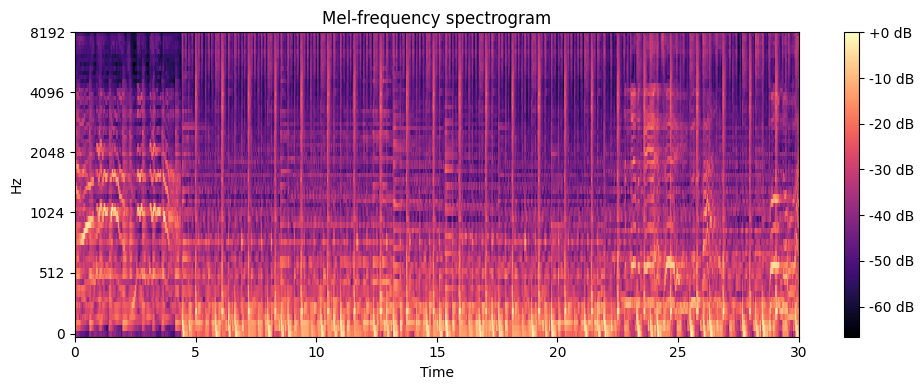

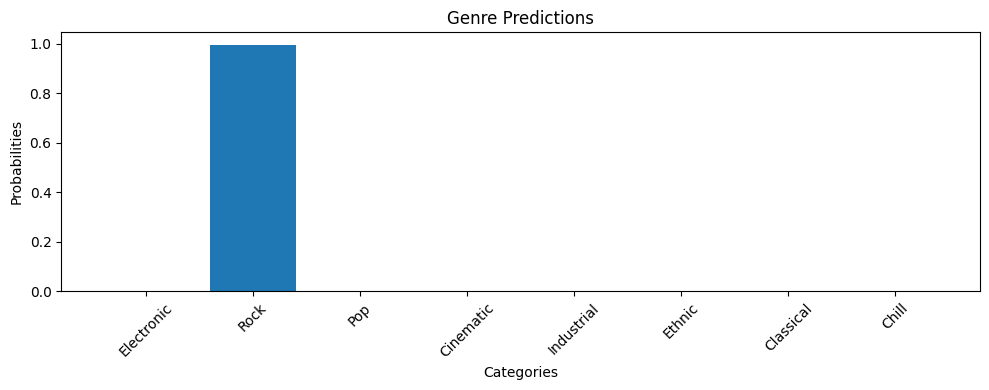

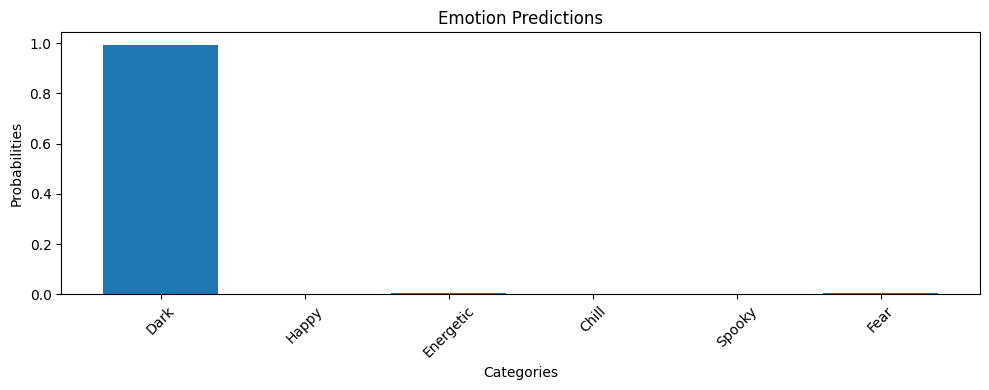

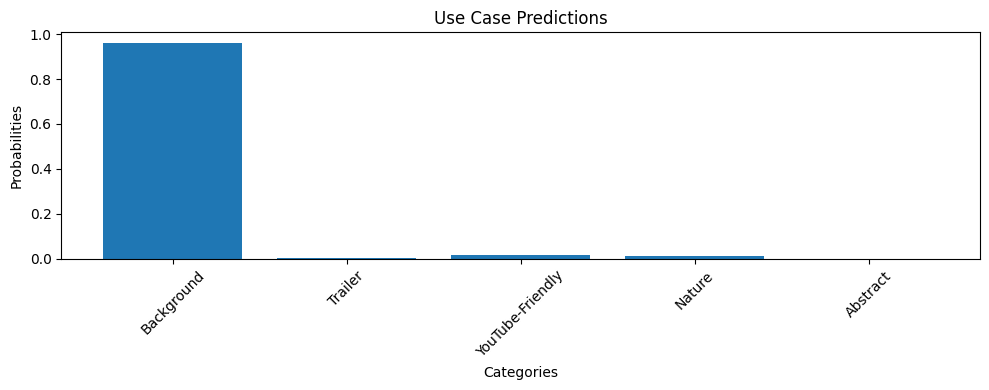

In [33]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def plot_mel_spectrogram(audio_path):
    y, sr = librosa.load(audio_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

def plot_probabilities(probabilities, category_names, title):
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(probabilities)), probabilities, tick_label=category_names)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel('Probabilities')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
audio_path = audio_paths[0]  # Assuming audio_paths is a list of paths
plot_mel_spectrogram(audio_path)

# Assuming genre_data, mood_data, and use_case_data are dictionaries with category names
genre_names = [genre_data[i][1] for i in range(8)]
emotion_names = [mood_data[i][1] for i in range(6)]
usecase_names = [use_case_data[i][1] for i in range(5)]

# Plot probabilities
genre_probs = probabilities[0, :8].cpu().numpy()
emotion_probs = probabilities[0, 8:14].cpu().numpy()
usecase_probs = probabilities[0, 14:].cpu().numpy()

plot_probabilities(genre_probs, genre_names, 'Genre Predictions')
plot_probabilities(emotion_probs, emotion_names, 'Emotion Predictions')
plot_probabilities(usecase_probs, usecase_names, 'Use Case Predictions')